
This is the lstm model for forecasting kospi volatility

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import data_reader as dr


In [2]:
data, source = dr.read('kospi.csv')

Loading data from file /home/changhyun/workspace/cxk858/dataset/kospi.csv...



In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 1 to 2483
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 2471 non-null   object 
 1   Open                 2471 non-null   float64
 2   High                 2471 non-null   float64
 3   Low                  2471 non-null   float64
 4   Close                2471 non-null   float64
 5   Adj Close            2471 non-null   float64
 6   Volume               2471 non-null   float64
 7   Daily_trading_range  2471 non-null   float64
 8   Log_Volume_change    2471 non-null   float64
 9   Daily_return         2471 non-null   float64
 10  Daily_log_return     2471 non-null   float64
 11  Past_vol22           2450 non-null   float64
 12  Past_vol10           2462 non-null   float64
 13  Target22             2450 non-null   float64
dtypes: float64(13), object(1)
memory usage: 289.6+ KB


In [36]:
data = data.drop(['Adj Close', 'Open', 'High', 'Close', 'Volume', 'Low','Daily_return'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 1 to 2483
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 2471 non-null   object 
 1   Daily_trading_range  2471 non-null   float64
 2   Log_Volume_change    2471 non-null   float64
 3   Daily_log_return     2471 non-null   float64
 4   Past_vol22           2450 non-null   float64
 5   Past_vol10           2462 non-null   float64
 6   Target22             2450 non-null   float64
dtypes: float64(6), object(1)
memory usage: 154.4+ KB


In [37]:
x_values = data.iloc[22:, 1:-2]
y_values = data[['Target22']]
y_values = y_values.iloc[22:]

In [38]:
x_values.info()
y_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2449 entries, 23 to 2483
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Daily_trading_range  2449 non-null   float64
 1   Log_Volume_change    2449 non-null   float64
 2   Daily_log_return     2449 non-null   float64
 3   Past_vol22           2449 non-null   float64
dtypes: float64(4)
memory usage: 95.7 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2449 entries, 23 to 2483
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Target22  2449 non-null   float64
dtypes: float64(1)
memory usage: 38.3 KB


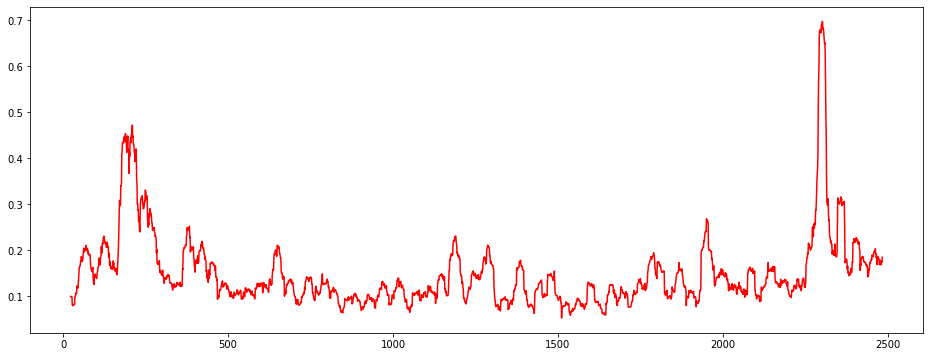

In [39]:
plt.figure(1, figsize=(16,6))
plt.plot(y_values, color='red')

In [40]:
scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(x_values)
scaled_y = scaler.fit_transform(y_values)

In [41]:

y_values

,Target22
23,0.099205
24,0.098520
25,0.098654
26,0.098439
27,0.098112
...,...
2479,0.167926
2480,0.176696
2481,0.175393
2482,0.173015


In [42]:
split = int(len(x_values)*0.8)

In [43]:
window = 22
trainX = np.array(scaled_x[:split])
testX = np.array(scaled_x[split:])
trainY = np.array(scaled_y[:split])
testY = np.array(scaled_y[split:])

trainX.shape

(1959, 4)

In [44]:
Xtrain = []
ytrain = []
Xtest = []
ytest = []

for i in range(window, len(trainX)):
    Xtrain.append(trainX[i-window:i, :trainX.shape[1]])
    ytrain.append(trainY[i])
for i in range(window, len(testX)):
    Xtest.append(testX[i-window:i, :testX.shape[1]])
    ytest.append(testY[i])

In [45]:
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

In [46]:

print(Xtrain.shape)
print(ytrain.shape)
print("-----")
print(Xtest.shape)
print(ytest.shape)

(1937, 22, 4)
(1937, 1)
-----
(468, 22, 4)
(468, 1)


In [47]:
print(trainX)

[[0.06086856 0.51970406 0.55774495 0.05329345]
 [0.02894888 0.49489247 0.50784862 0.05513522]
 [0.14083572 0.50850311 0.50119657 0.05568919]
 ...
 [0.03632349 0.48998891 0.55153895 0.13550021]
 [0.24336809 0.49456064 0.42510235 0.14544362]
 [0.09966974 0.53132158 0.46730555 0.14581402]]


In [48]:
print(trainY)

[[0.07281521]
 [0.07175264]
 [0.07196146]
 ...
 [0.13623368]
 [0.15021518]
 [0.15383881]]


In [49]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from tensorflow import keras

In [68]:
model = Sequential()
model.add(LSTM(units=10, return_sequences=False, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
# model.add(Dropout(0.3))
# model.add(LSTM(units=4, return_sequences=False))
# model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(Xtrain, ytrain, batch_size=16, epochs=20, validation_split=0.1, shuffle=False)

Epoch 1/20
109/109 [==============================] - 4s 12ms/step - loss: 0.0599 - val_loss: 0.0070

In [69]:
# previous_model = keras.models.load_model('models/multi_layer_lstm_model')

In [70]:
forecast = model.predict(Xtest)

In [71]:
rev_forecast = scaler.inverse_transform(forecast)
rev_ytest = scaler.inverse_transform(ytest)

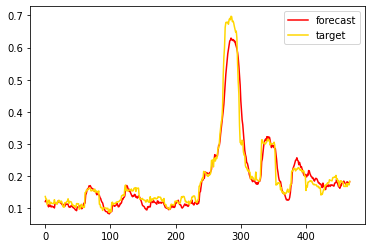

In [74]:
plt.plot(rev_forecast, color='red', label='forecast')
plt.plot(rev_ytest, color='gold', label='target')
plt.legend()
plt.savefig("images/single_layer_model_pred.png")

plt.show()

In [73]:
testScore = mean_squared_error(rev_ytest, rev_forecast)
print("test Score: {score} MSE".format(score=testScore))
root_testScore = mean_squared_error(rev_ytest, rev_forecast, squared=False)
print("test Score: {score} RMSE".format(score=root_testScore))
mape = mean_absolute_percentage_error(rev_ytest, rev_forecast)
print("test Score: {score} MAPE".format(score=mape))

test Score: 0.0009346285363471279 MSE
test Score: 0.03057169501920245 RMSE
test Score: 0.08919866794319291 MAPE


In [275]:
# model.save("models/single_layer_lstm_model")

INFO:tensorflow:Assets written to: models/single_layer_lstm_model/assets


INFO:tensorflow:Assets written to: models/single_layer_lstm_model/assets


## Experiment settings

Dataset: KOSPI index from Jan, 2011 to Dec, 2020\
Included data in default: Daily log return, Daily trading range, Log volume change\
Additional data for hybrid: Next prediction by GARCH and GJR-GARCH

- Loss function: mean_squared_error
- Optimizer: Adam
- epochs: 20
- batch_size: 16

## Experiment results


- Single-layer lstm model (32 units)
    * Training error: 0.0042, Validation error: 0.0031
    * MSE: 0.0032
    * RMSE: 0.0568
    * MAPE 0.1912

![title](images/single_layer_model_pred.png)

- Multi-layer lstm model (32 units, dropout 0.3, 32 units)
    * Training error: 0.0045, Validation error: 0.0024
    * MSE: 0.0023
    * RMSE 0.0484
    * MAPE: 0.1701
    
![title](images/multi_layer_model_pred.png)

- Single-layer hybrid model (32 units)
    * Training error: 0.0016, Validation error: 0.0001
    * MSE: 0.0007
    * RMSE: 0.0269
    * MAPE: 0.0924

![title](images/single_layer_hybrid_pred.png)

- Multi-layer hybrid model (32 units, dropout 0.3, 32 units)
    * Training error: 0.0024, Validation error: 0.0001
    * MSE: 0.0008
    * RMSE: 0.0274
    * MAPE: 0.0935
    
![title](images/multi_layer_hybrid_pred.png)